# Tutorial 4: MBHBs & MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *

In the fourth tutorial we will examine MBHB waveforms. We will examine how to generate waveforms, add the LISA response, calculate the Likelihood, and then we will run an MCMC with MBHBs. 

## Task 1: Generate IMRPhenomHM waveforms

We will start by generating IMRPhenomHM waveforms for MBHBs. Pick reasonable parameters, build a waveform and plot it against the LISA Sensitivity Curve (`LISASens`) in the characteristic strain representation. **Hint**: set `f_ref = 0.0`. You can access the information after waveform generation as attributes on the class. This may be updated

Useful documentation:
* [PhenomHMAmpPhase](https://mikekatz04.github.io/BBHx/html/user/waveforms.html#bbhx.waveforms.phenomhm.PhenomHMAmpPhase)

In [2]:
# imports 
from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from lisatools.sensitivity import get_sensitivity

No CuPy or GPU PhenomHM module.


In [3]:
wave_gen = PhenomHMAmpPhase()

m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
t_ref = 1e6 # seconds
length = 1024

wave_gen(m1, m2, chi1, chi2, dist, phi_ref, f_ref, t_ref, length)

Text(0, 0.5, 'Characteristic Strain')

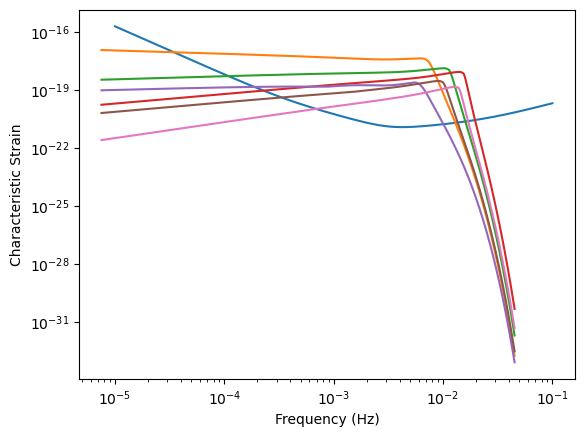

In [4]:
fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="LISASens", return_type="char_strain") 


plt.loglog(fn, Sn_char_strain)
for i in range(6):
    char_strain = wave_gen.freqs * wave_gen.amp[0, i]
    plt.loglog(wave_gen.freqs, char_strain)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")

## Task 2: Add the response. 

Now repeat the same task as above by adding the response. In `BBHx`, the response is added automatically for you using the main waveform production class: `BBHWaveformFD`. The sensitivity for this should be `A1TDISens`.

Useful Documentation:
* [BBHWaveformFD](https://mikekatz04.github.io/BBHx/html/user/main.html#bbhx.waveformbuild.BBHWaveformFD)

In [5]:
# imports
from bbhx.waveformbuild import BBHWaveformFD

No CuPy
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [6]:
tdi_wave_gen = BBHWaveformFD()

In [7]:
m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
inc = np.pi / 8
lam = 3.4
beta = -0.7
psi = np.pi/4
t_ref = 1e6 # seconds

length = 1024

# setup data holders
Tobs = YRSID_SI / 12.  # 1 month
dt = 10.0  # sec
N = int(Tobs / dt)
Tobs = N * dt

freqs = np.fft.rfftfreq(N, dt)

AET = tdi_wave_gen(
    m1,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    length=1024, 
    combine=False,  # TODO: check this
    direct=False,
    fill=True,
    squeeze=True,
    freqs=freqs
)

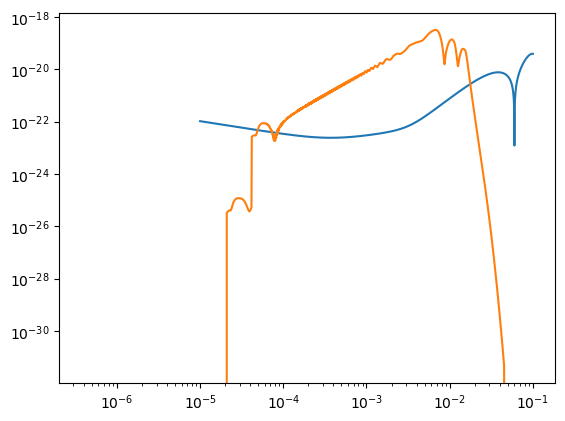

In [8]:
fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
plt.loglog(fn, Sn_char_strain)
plt.loglog(freqs, freqs * np.abs(AET[0,0]))

## Task 3: Inject an MBHB and compute its SNR

Now we will combine our knowledge of `lisatools` with `bbhx`. Using the same methods above, setup a full `AnalysisContainer` and inject an MBHB signal. Calculate its SNR. 

In [9]:
# imports
from lisatools.sensitivity import AET1SensitivityMatrix
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer

In [10]:
def wrap(*args, **kwargs):
    return tdi_wave_gen(*args, **kwargs)[0]

In [11]:
data = DataResidualArray(AET[0], f_arr=freqs)
sens_mat = AET1SensitivityMatrix(data.f_arr)
analysis = AnalysisContainer(data, sens_mat, signal_gen=wrap)

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:84: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:86: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:88: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:93: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:95: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0

In [12]:
analysis.snr()

3233.4754750915527

Calculate the Likelihood using `calculate_signal_likelihood`. 

In [13]:
analysis.calculate_signal_likelihood(
    m1 * 1.0001,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=freqs
    ),
    source_only=True
    # data_arr_kwargs=dict(f_arr=freqs)
)

-7.643172536045313

## Task 4: MCMC with MBHBs

Now we will run an MCMC for MBHBs. Use your knowledge from our tutorial on `Eryn` to run an MCMC for MBHBs. Let's run it for over four parameters: `(mT, q, phi_ref, t_ref)`. You can use an `Eryn` [TransformContainer](https://mikekatz04.github.io/Eryn/html/user/utils.html#transformcontainer) or a wrapper Likelihood to fill in fixed parameters and make necessary transformations. **Remember**: the waveform generator takes `m1` and `m2`, so you will need to transform these inside the Likelihood function. You can use the `periodic` kwarg for `EnsembleSampler` to run `phi_ref` as a periodic variable wrapping over the edge.

This will not be fast. Run the sampler for a small number of samples and move on to the next step. 

In [14]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

In [15]:
def wrapper_likelihood(x, fixed_parameters, freqs, analysis, **kwargs):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = analysis.calculate_signal_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
            length=1024, 
            combine=False,  # TODO: check this
            direct=False,
            fill=True,
            squeeze=True,
            freqs=freqs
        ),
        source_only=True
        # data_arr_kwargs=dict(f_arr=freqs)
    )
    return ll

In [16]:
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(1e5, 5e6),
    1: uniform_dist(0.05, 0.999999),
    2: uniform_dist(0.0, 2 * np.pi),
    3: uniform_dist(0.0, Tobs + 24 * 3600.0),
})}

injection_params = np.array([
    m1 + m2,
    m2 / m1,
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref
])

fixed_parameters = np.array([
    chi1,
    chi2,
    dist, 
    f_ref, 
    inc,
    lam,
    beta,
    psi,
])

periodic = {"mbh": {2: 2 * np.pi}}

ntemps = 10
nwalkers = 32
ndims = {"mbh": 4}
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
    periodic=periodic
)

In [17]:
injection_params

array([ 2.70000000e+06,  3.50000000e-01,  5.00000000e-01,  7.00000000e-01,
        4.62851637e+26,  6.00000000e-01,  0.00000000e+00,  3.92699082e-01,
        3.40000000e+00, -7.00000000e-01,  7.85398163e-01,  1.00000000e+06])

In [18]:
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-4 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))
start_state = State({"mbh": start_params})
sampler.compute_log_prior(start_state.branches_coords)
sampler.run_mcmc(start_state, 10, progress=True)

100%|███████████████████████████████████████████| 10/10 [05:43<00:00, 34.31s/it]


## Task 5: Add heterodyning for speed

That would take a long time to complete a sampling run. One technique for speeding up waveforms is called `heterodyning`. Wrap the Heterodyned likelihood to use a subset of parameters. You can also use an Eryn `TransformFunction`. 

Useful Documentation:

* [HeterodynedLikelihood](https://mikekatz04.github.io/BBHx/html/user/like.html#bbhx.likelihood.HeterodynedLikelihood)

In [19]:
# imports
from bbhx.likelihood import HeterodynedLikelihood

No CuPy


In [20]:
# how many frequencies to use
length_f_het = 128

mT = injection_params[0]
q = injection_params[1]

transformed_injection_params = injection_params.copy()
transformed_injection_params[0] = mT / (1 + q)
transformed_injection_params[1] = mT * q / (1 + q)
# initialize Likelihood
like_het = HeterodynedLikelihood(
    tdi_wave_gen,
    freqs,
    data[:],
    transformed_injection_params,
    length_f_het,
)

like_het.get_ll(transformed_injection_params[None, :].T)

array([-0.00275878])

In [21]:
def het_wrapper_likelihood(x, fixed_parameters, freqs, het_like):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)

    # 
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = like_het.get_ll(all_parameters)
    return ll

In [22]:
injection_params

array([ 2.70000000e+06,  3.50000000e-01,  5.00000000e-01,  7.00000000e-01,
        4.62851637e+26,  6.00000000e-01,  0.00000000e+00,  3.92699082e-01,
        3.40000000e+00, -7.00000000e-01,  7.85398163e-01,  1.00000000e+06])

In [23]:
ll_comp = wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, analysis)
ll_het = het_wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, like_het)
print(ll_het, ll_comp)

[-0.00275878] -1.862645149230957e-09


In [24]:
raise KeyboardInterrupt

KeyboardInterrupt: 

Let's check how well the heterodyning method matches the base likelihood by sampling our prior. You will have to update the reference template for each computation since we are drawing from the prior and may be far away from our true point. You can do this with `HeterodynedLikelihood.init_heterdyne_info`. 

In [ ]:
num = 10
for params in priors["mbh"].rvs(num):
    update_params = injection_params.copy()
    mT = params[0]
    q = params[1]
    m1 = mT / (1 + q)
    m2 = mT * q / (1 + q)
    update_params[np.array([0, 1, 5, 11])] = np.array([m1, m2, params[2], params[3]])
    like_het.init_heterodyne_info(
        update_params
    )
    ll_comp = wrapper_likelihood(params, fixed_parameters, freqs, analysis)
    ll_het = het_wrapper_likelihood(params, fixed_parameters, freqs, like_het)
    print(ll_comp, ll_het, np.abs(ll_comp - ll_het), np.abs(ll_comp - ll_het) / np.abs(ll_comp))

In [27]:
nwalkers = 32
het_sampler = EnsembleSampler(
    nwalkers,
    ndims,
    het_wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, like_het),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    periodic=periodic
)

In [45]:
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, 4))
start_params[:, :, :, 2] %= (2 * np.pi)
het_start_state = State({"mbh": start_params})
het_sampler.backend.reset(*het_sampler.backend.reset_args,**het_sampler.backend.reset_kwargs)
het_sampler.run_mcmc(het_start_state, 1000, burn=200, progress=True)

100%|███████████████████████████████████████| 1000/1000 [11:17<00:00,  1.48it/s]


In [46]:
het_sampler.compute_log_like(het_start_state.branches_coords)

(array([[-8.96293317e+01, -7.18099181e+00, -5.83481642e+01,
         -7.10964490e-01, -2.54974422e+01, -1.16908013e+02,
         -9.96898200e+00, -4.91720624e-03, -2.70637855e+01,
         -8.39323780e+00, -5.13695768e+01, -3.01010319e+00,
         -8.04280514e+01, -1.43812604e+01, -1.43270539e+00,
         -1.15090538e-01, -4.58333738e+00, -2.10806068e+02,
         -2.96857290e+01, -4.24336540e+01, -1.42369589e+01,
         -1.74608160e+01, -4.17722279e+01, -2.62500534e+01,
         -2.34279743e+00, -6.27592419e+01, -2.50599601e+00,
         -1.14589731e+01, -2.27605136e+01, -1.82915639e+01,
         -2.97699165e+02, -5.36356233e-02],
        [-4.93369926e+01, -1.30548395e+02, -7.98513192e+00,
         -1.05993470e+01, -1.25449386e+01, -4.15458149e+01,
         -4.21527684e+00, -5.80593653e-01, -9.43499794e+01,
         -1.33339087e+01, -3.11407293e+01, -1.98128813e+01,
         -1.04013520e+00, -5.84143823e-01, -4.85703775e+01,
         -1.10695018e+01, -7.88971470e+01, -1.68136439e+

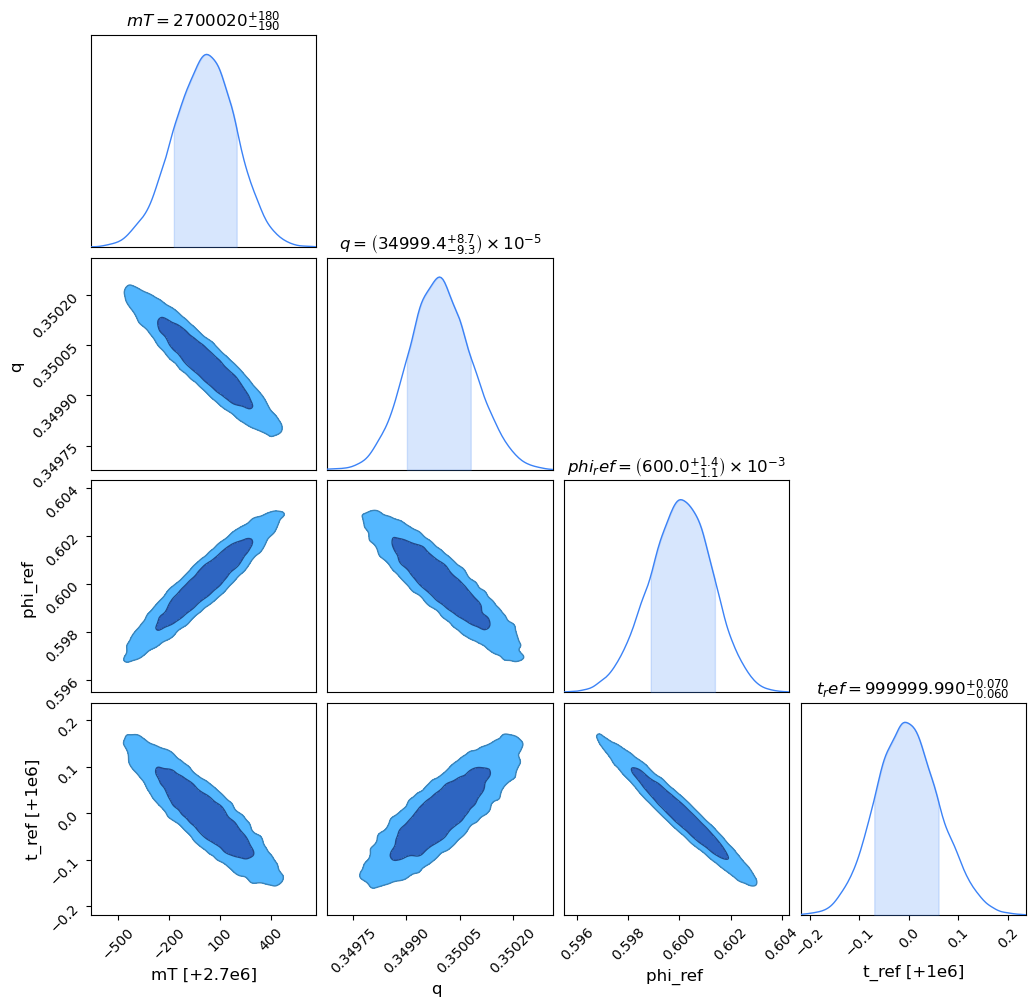

In [47]:
from chainconsumer import Chain, ChainConsumer, make_sample
import pandas as pd
samples = het_sampler.get_chain()["mbh"][:, 0].reshape(-1, 4)
df = pd.DataFrame(samples, columns=["mT", "q", "phi_ref", "t_ref"])
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
fig = c.plotter.plot()

In [48]:
het_sampler.get_log_like().max(axis=(1, 2))

array([-0.29431166, -0.29431166, -0.36380554, -0.16691047, -0.19387622,
       -0.17054481, -0.17054481, -0.17054481, -0.08548217, -0.11831994,
       -0.12204356, -0.12204356, -0.40206698, -0.40206698, -0.38903145,
       -0.14690481, -0.35169385, -0.278658  , -0.20266458, -0.12104433,
       -0.05407385, -0.09976317, -0.2312866 , -0.2312866 , -0.51461896,
       -0.16910017, -0.15272145, -0.37178085, -0.25438331, -0.28410297,
       -0.28410297, -0.13234801, -0.12379752, -0.14293157, -0.17172784,
       -0.17172784, -0.29028389, -0.19703957, -0.07733484, -0.14253255,
       -0.09789699, -0.3881    , -0.32312811, -0.14714711, -0.09193163,
       -0.12850063, -0.20026671, -0.2502916 , -0.38434191, -0.37377493,
       -0.11201819, -0.11201819, -0.11201819, -0.21190754, -0.41592982,
       -0.20516127, -0.41592982, -0.21164504, -0.23307475, -0.23307475,
       -0.23307475, -0.19446407, -0.14098107, -0.0560105 , -0.0560105 ,
       -0.0560105 , -0.34053905, -0.34053905, -0.34053905, -0.08

In [49]:
het_sampler.get_log_like()[-1]

array([[-1.23700907e+00, -4.11289686e-01, -1.83711263e+00,
        -2.78912930e-01, -1.03454479e+00, -2.42166162e+00,
        -1.30174994e+00, -1.33111040e+00, -7.48767558e-01,
        -3.31044976e-01, -4.62554473e+00, -8.31118155e-01,
        -1.57207575e+00, -3.27474434e+00, -3.78520397e-01,
        -2.77453046e+00, -1.33656497e+00, -1.14462511e+00,
        -7.30911497e-01, -1.61940884e+00, -1.23057796e+00,
        -4.63236203e-01, -3.95573805e+00, -2.69110950e-01,
        -1.17143322e+00, -7.07792038e-01, -2.27319204e+00,
        -1.53431788e+00, -1.40818438e-01, -2.47188478e+00,
        -1.27783756e+00, -4.39010249e-01],
       [-4.86872967e+00, -4.30552412e+00, -7.81570632e+00,
        -1.35471699e+01, -3.85979199e+00, -1.50108339e+01,
        -3.50522259e+00, -4.13241814e+00, -1.92322135e+00,
        -3.15974879e+00, -1.60277217e+00, -2.20811526e+01,
        -8.31241776e+00, -5.86721222e+00, -2.88275952e+00,
        -1.16203076e+01, -8.65101703e+00, -1.05839270e+01,
        -6.44